<a href="https://colab.research.google.com/github/gmazzitelli/studenti/blob/master/scope_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Inizializzation.

This Cell download and intstall ROOT in python 2 environment. 

Runs this part of the script only when you have to init a new machine e and working space

In [0]:
# sitallazione di ROOT dal CERN
!mkdir -p APPS
!pwd
!cd APPS && wget https://root.cern.ch/download/root_v6.13.08.Linux-ubuntu18-x86_64-gcc7.3.tar.gz 
!cd APPS && tar -xf root_v6.13.08.Linux-ubuntu18-x86_64-gcc7.3.tar.gz

# main paths for ROOT  
import sys
sys.path.append("/content/APPS/root/lib")
import ctypes
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libCore.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libThread.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libImt.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libRIO.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libNet.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libTree.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libMathCore.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libMatrix.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libHist.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libGraf.so')
# itsllation and root-numpy main PATH
!pip install root-numpy
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libMultiProc.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libGpad.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libGraf3d.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libTreePlayer.so')
# patch to open online FILE
! sudo apt-get install libdavix0v5
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libRDAVIX.so')
! echo "Davix.GSI.CACheck: n" >> $ROOTSYS/etc/system.rootrc
! cp $ROOTSYS/etc/system.rootrc $HOME/.rootrc
! tail -1 $HOME/.rootrc

This Cell Load funcions (libraries) to retrive data from swift CYGNO server

Runs this part of the script only when you have to init a new machine e and working space

In [0]:
!pip install -q  python-swiftclient
!pip install -q  keystoneauth1
!pip install -q  h5py
import matplotlib.pyplot as plt
import numpy as np    
import ROOT
import root_numpy as rtnp
! rm cygnus_lib.*; rm mylib.*
! wget https://raw.githubusercontent.com/gmazzitelli/cygno/master/cygnus_lib.py
! wget https://raw.githubusercontent.com/gmazzitelli/cygno/master/mylib.py
sys.path.append('.')
import cygnus_lib as cy
import mylib as my
%matplotlib inline
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import chisquare
import scipy.stats as stats
from itertools import combinations
import math
import os

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

x_resolution = y_resolution = 2048
plt.rc('font', size = 14, family ='Sans-Serif')
!mkdir -p data

In [0]:
def TGraph2array(tgraph, negative=True):
  xl = []; yl = []
  ysign = -1 if negative else 1
  for i in range(tgraph.GetN()):
      xi = ctypes.c_double(); yi = ctypes.c_double()
      tgraph.GetPoint(i,xi,yi)
      xl.append(xi.value)
      yl.append(ysign*yi.value)
  x = np.array(xl)
  y = np.array(yl)
  return x, y

Reference

[berain](https://towardsdatascience.com/whos-talking-using-k-means-clustering-to-sort-neural-events-in-python-e7a8a76f316)

[music](https://towardsdatascience.com/how-to-apply-machine-learning-and-deep-learning-methods-to-audio-analysis-615e286fcbbc)

1) Data delection

running 0


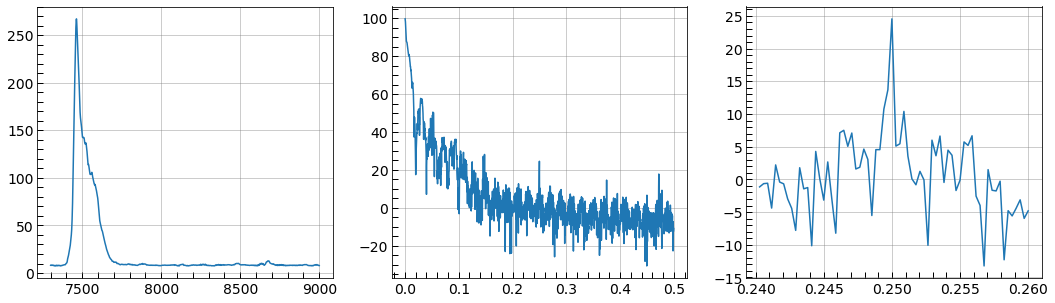

running 10


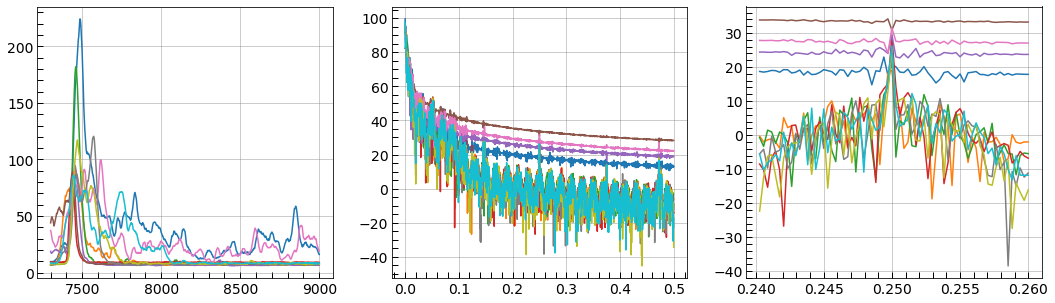

running 20


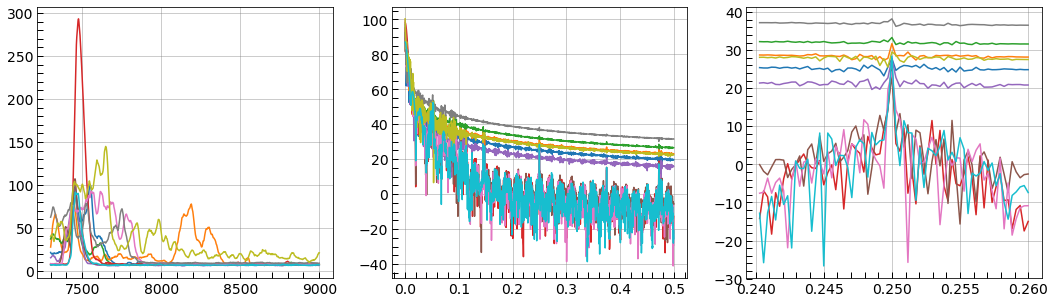

running 30


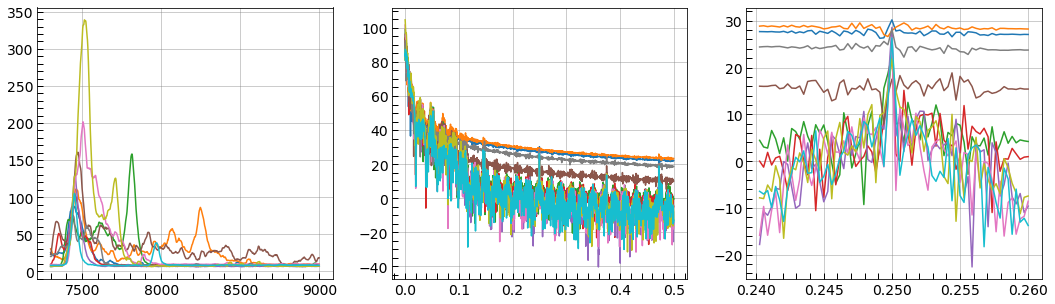

running 40


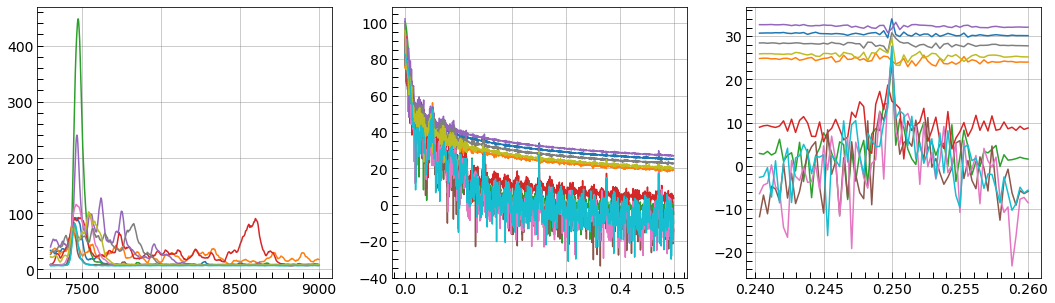

running 50


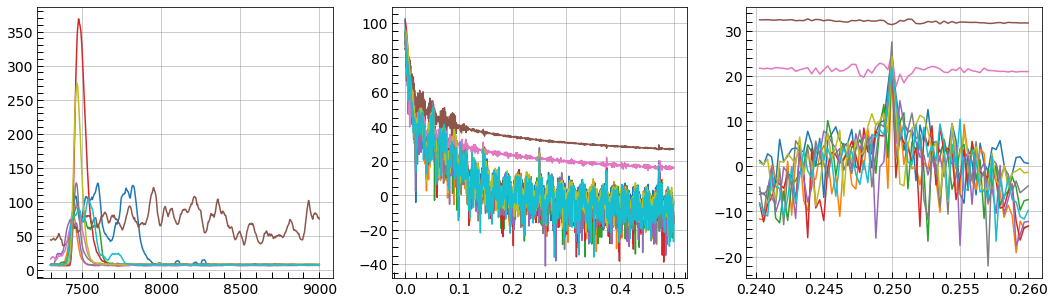

running 60


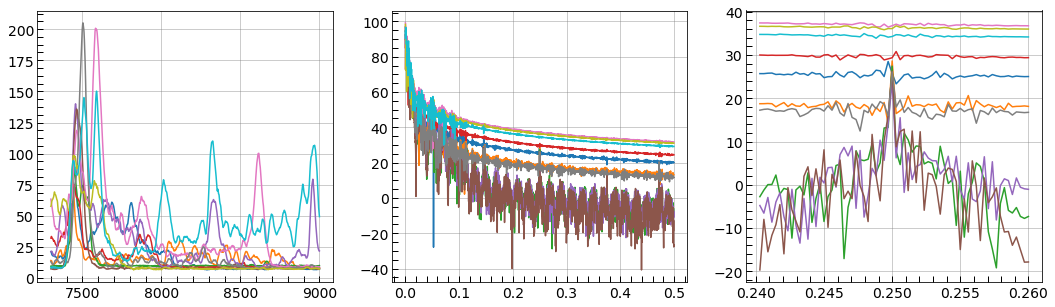

running 70


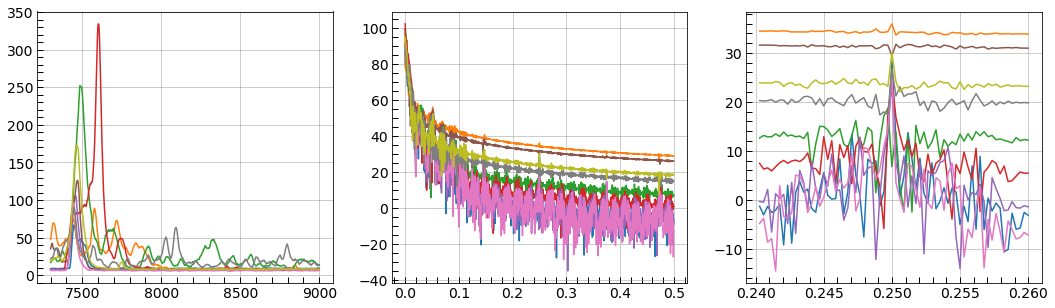

running 80


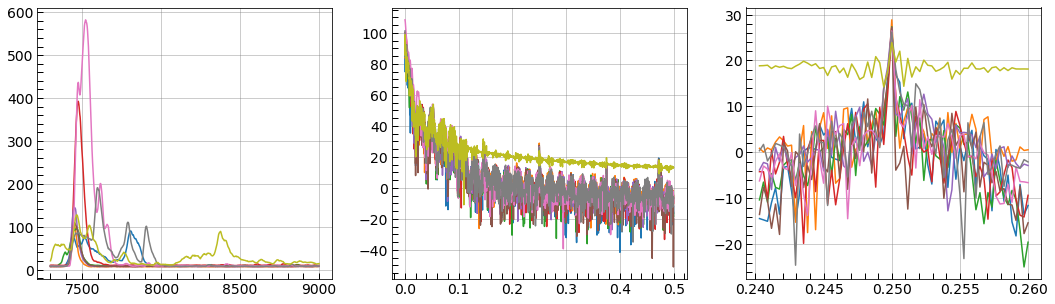

running 90


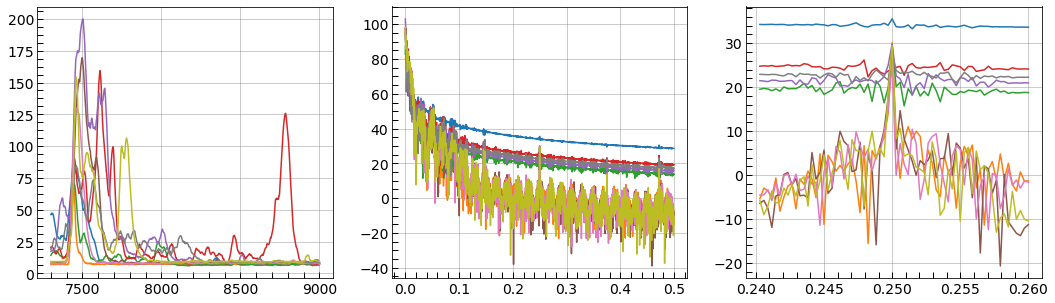

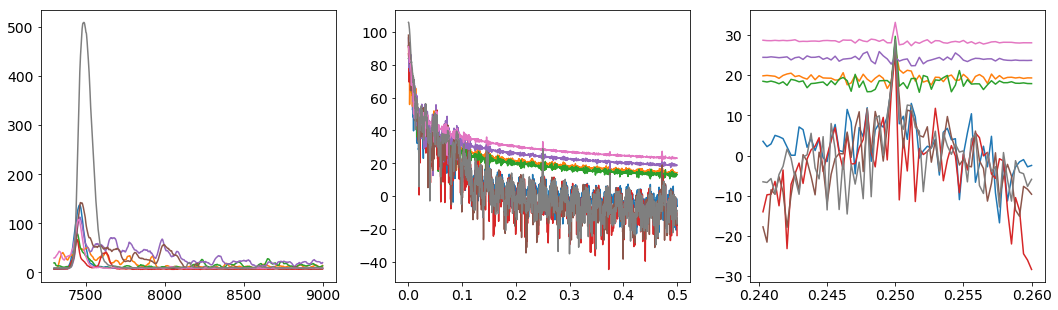

In [4]:

plt.rc('font', size = 14, family ='Sans-Serif')
run = 2098
#
f  = ROOT.TFile.Open('https://swift.cloud.infn.it:8080/v1/AUTH_1e60fe39fba04701aa5ffc0b97871ed8/Cygnus/Data/LAB/histograms_Run{0:05d}.root'.format(run));
pic, wfm = cy.root_TH2_name(f)
#
fig, ax = plt.subplots(1,3, figsize=(18,5))
# Ch = []
# wayform = []
df = pd.DataFrame(columns = ['iTr', 'Charge', 'Peak', 'Peck_position','Dt', 'waveform'])
scope_th = 30
for iTr in range(100):

  # fig, ax = plt.subplots(1,3, figsize=(15,5))
  # image = rtnp.hist2array(f.Get(pic[iTr])).T
  t,A = TGraph2array(f.Get(wfm[iTr]))
  offset_int = 100
  if (A+offset_int).mean()>0:
    cut = (t>7300) & (t<9000)
    ts = cy.smooth(t, 100)[cut]
    As = cy.smooth(A, 100)[cut]+abs(A.min())

    ax[0].plot(ts,As)
    
    signalFFT = np.fft.rfft(As)
    signalPSD = np.abs(signalFFT) ** 2
    fftFreq = np.fft.fftfreq(len(signalPSD))
    i = fftFreq>0
    Amp = 10*np.log10(signalPSD[i])
    ax[1].plot(fftFreq[i], Amp)
    ThArr = my.OverTh2Array(As, scope_th)
    Dt = (ThArr[-1][0] - ThArr[0][0])

    s_cut = (fftFreq[i]>0.24) & (fftFreq[i]<0.26)
    ax[2].plot(fftFreq[i][s_cut], Amp[s_cut])
    # ax[2].set_xlim(0.14, 0.16)
    # ax[2].imshow(image,  cmap="jet", vmin=95,vmax=120)
    # Ch.append([iTr, np.trapz(As, ts), As.max(), ts[np.argmax(As)], Dt])
    # wayform.append([As]) 
    df = df.append({'iTr': iTr, 'Charge' : np.trapz(As, ts), 'Peak' : As.max(),
              'Peck_position' : ts[np.argmax(As)], 'Dt':  Dt, 'waveform': As} , ignore_index=True)

    if iTr%10==0:
      print('running '+str(iTr))
      # print(Ch[-1])
      ax[0].minorticks_on()
      ax[0].grid()
      ax[0].tick_params(axis="both", direction='in', which="both", length=6, width=1, colors='k',
                grid_color='grey', grid_alpha=0.5)
      ax[1].minorticks_on()
      ax[1].grid()
      ax[1].tick_params(axis="both", direction='in', which="both", length=6, width=1, colors='k',
                      grid_color='grey', grid_alpha=0.5)
      ax[2].minorticks_on()
      ax[2].grid()
      ax[2].tick_params(axis="both", direction='in', which="both", length=6, width=1, colors='k',
                      grid_color='grey', grid_alpha=0.5)
      #ax[0].set_ylim(-600, 50)
      plt.show()
      fig, ax = plt.subplots(1,3, figsize=(18,5))



In [0]:
#
# save and copy to my drive data output
#
df.to_pickle('./data/waveform.plk')
!gzip data/waveform.plk
from google.colab import drive
drive.mount('/content/drive')
!ls data/
#!ls -lh /content/drive/My\ Drive/Colab\ Notebooks
! cp -v data/waveform.plk.gz /content/drive/My\ Drive/Colab\ Notebooks/
# 

2) DB contents

In [6]:
df.tail()

,iTr,Charge,Peak,Peck_position,Dt,waveform
91,94,17353.686523,66.767578,7445.625,909,"[6.884765625, 6.884765625, 6.865234375, 6.8359..."
92,96,54684.827881,112.880859,7463.625,3725,"[7.587890625, 7.607421875, 7.63671875, 7.67578..."
93,97,41562.448730,142.441406,7467.375,2649,"[7.67578125, 7.6953125, 7.724609375, 7.7539062..."
94,98,24604.577637,108.027344,7456.875,815,"[29.4140625, 29.53125, 29.658203125, 29.804687..."
95,99,66259.345703,509.697266,7488.625,746,"[9.091796875, 9.0625, 9.0234375, 8.994140625, ..."


In [0]:
#fig, ax = plt.subplots(figsize=(10,5))
#plt.hist(Ch[:,1], bins=100, range=(10000,100000))

df.hist(bins=100, figsize=(10,10))


plt.show()

3) Kmeans, maximazi number of cluster with WWCS method, loks ~ 4-5 is ok

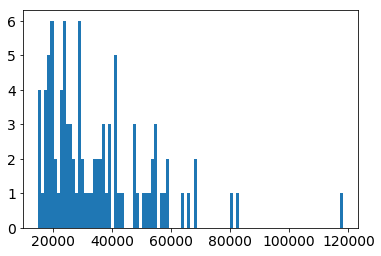

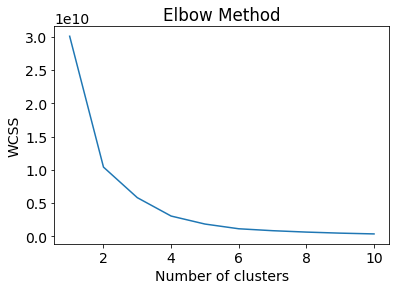

In [8]:
from sklearn.cluster import KMeans
#plt.scatter(Ch[:,0], Ch[:,1])
plt.hist(df['Charge'], bins=100)
plt.show()
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df.loc[:,['Charge', 'Peak', 'Peck_position',	'Dt']])
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

4) apply kmeans to 'Charge', 'Peak', 'Peck_position',	'Dt' futures and show selction on charge spectra 

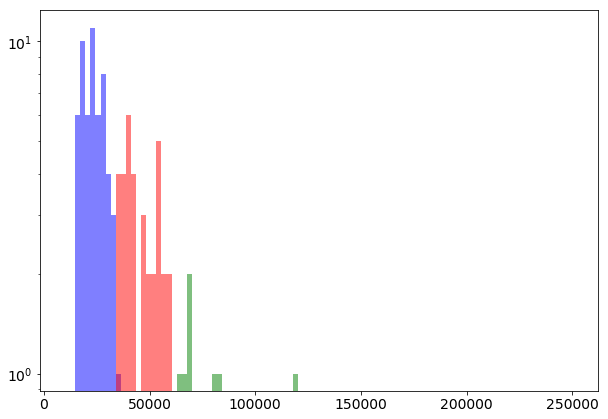

In [9]:
fig, ax = plt.subplots(figsize=(10,7))
from mpl_toolkits.mplot3d import Axes3D
#ax = Axes3D(fig)
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(df.loc[:,['Charge', 'Peak', 'Peck_position',	'Dt']])
#plt.scatter(Ch[:,0], Ch[:,1],  Ch[:,2])
#plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
#labels = kmeans.labels_
#plt.scatter(Ch[:,0], Ch[:,2], c=labels.astype(np.float))
#plt.hist(df['Charge'], bins=100, color=labels.astype(np.float))
plt.hist(df['Charge'][pred_y==0], bins=100, color='b', alpha=0.5, range=(10000, 250000))
plt.hist(df['Charge'][pred_y==1], bins=100, color='g', alpha=0.5, range=(10000, 250000))
plt.hist(df['Charge'][pred_y==2], bins=100, color='r', alpha=0.5, range=(10000, 250000))
#plt.hist(df['Charge'][pred_y==3], bins=100, color='r', alpha=0.5, range=(10000, 250000))
plt.yscale('Log')
plt.show()

5) apply kMeans to waveforms

fit done


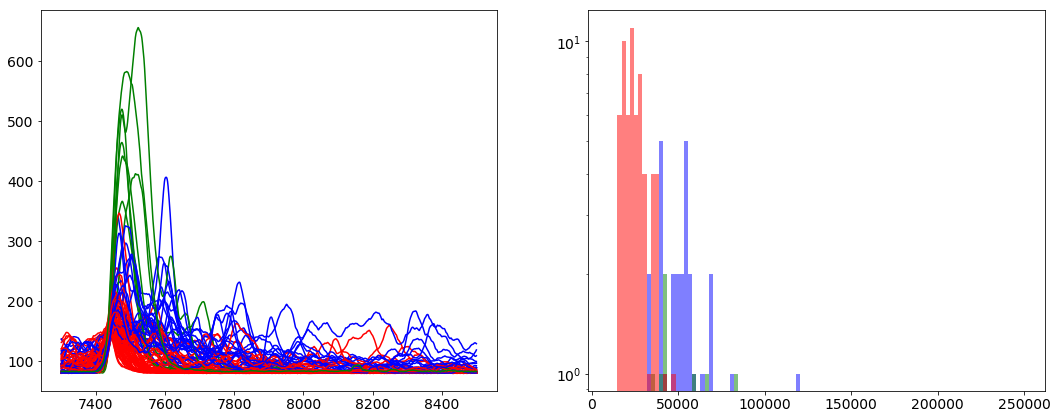

In [12]:
waveforms = []
for i in range (len(df)):
  waveforms.append([df.iloc[i,5]])

kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)

pred_y = kmeans.fit_predict(np.array(waveforms)[:,0])

print ('fit done')
fig, ax = plt.subplots(1,2, figsize=(18,7))
for i in range(len(pred_y)):
  iTr = df.iloc[i,0]
  t,A = TGraph2array(f.Get(wfm[iTr]))
  cut = (t>7300) & (t<8500)
  ts = cy.smooth(t, 100)[cut]
  As = cy.smooth(A, 100)[cut]+offset_int
  # ts = np.linspace(7300, 8500, len(waveforms[i]))
  # As = waveforms[i]
  if pred_y[i] == 0:
    ax[0].plot(ts,As, 'b')
    
  if pred_y[i] == 1:
    ax[0].plot(ts,As, 'g')
    
  if pred_y[i] == 2:
    ax[0].plot(ts,As, 'r')


ax[1].hist(df['Charge'][pred_y==0], bins=100, color='b', alpha=0.5, range=(10000, 250000))
ax[1].hist(df['Charge'][pred_y==1], bins=100, color='g', alpha=0.5, range=(10000, 250000))
ax[1].hist(df['Charge'][pred_y==2], bins=100, color='r', alpha=0.5, range=(10000, 250000))
ax[1].set_yscale('Log')
plt.show()

-31252.736083984375


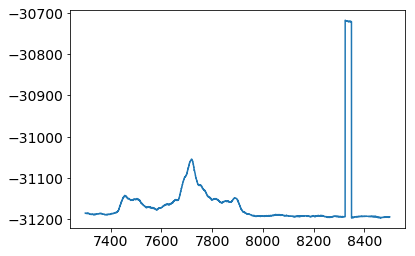

In [11]:
iTr = 95
t,A = TGraph2array(f.Get(wfm[iTr]))
print ((A+100).mean())

cut = (t>7300) & (t<8500)
ts = cy.smooth(t, 100)[cut]
As = cy.smooth(A, 100)[cut]

plt.plot(ts,As+100)
plt.show()